In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from lightgbm import LGBMClassifier
import gc
import os
import re
import json

%aimport src.utils.plot
%aimport src.utils
%aimport src.feats

import src.utils as utils
import src.feats as feats



# %afrom src.utils import utils
# %afrom src.feats import feats

In [21]:
 train = utils.read_csv('./input/application_train.csv')
 test = utils.read_csv('./input/application_test.csv')
 prev = utils.read_csv('./input/previous_application.csv')
 buro = utils.read_csv('./input/bureau.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [22]:
feats.app_features(train)
feats.app_features(test)
feats.prev_features(prev)

In [23]:
categorical_feats = [
    f for f in train.columns if train[f].dtype == 'object'
]

In [24]:
for f in categorical_feats:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [25]:
gc.enable()

In [26]:
y = train['TARGET']
del train['TARGET']

In [27]:
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

In [28]:
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

In [29]:
buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
for f_ in buro_cat_features:
    buro[f_], _ = pd.factorize(buro[f_])

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

In [30]:
train = train.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
train = train.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')


In [31]:
excluded_feats = ['SK_ID_CURR', 'HOUR_APPR_PROCESS_START']
excluded_feats = sum(list(map(lambda c: [c, f"{c}_x", f"{c}_y"], excluded_feats)), [])
features = [f_ for f_ in train.columns if f_ not in excluded_feats]
features

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG'

In [32]:
# trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=42)

In [33]:
# params = {
#     'n_estimators': 4000,
#     'learning_rate': 0.01,
#     'num_leaves': 63,
#     'colsample_bytree': .8,
#     'subsample': .8,
#     'subsample_freq': 5,
#     'max_depth': 5,
#     'reg_alpha': .001,
#     'reg_lambda': .1,
#     'min_split_gain': .01,
#     'device': "gpu",
# #     'categorical_feature': 'name:CODE_GENDER'
# }


# clf = LGBMClassifier(**params)

# eval_set = [(trn_x, trn_y), (val_x, val_y)]

# %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

# trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
# val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
# test_preds = clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

# trn_auc = roc_auc_score(trn_y, trn_preds)
# auc = roc_auc_score(val_y, val_preds)
# print('AUC : %.6f' % auc)
# gc.collect()

# config = {
#     'model': 'lgbm',
#     'params': params,
#     'trn_auc': trn_auc,
#     'auc': auc,
#     'features': features
# }

In [34]:
test_preds = np.zeros(test.shape[0])
trn_aucs = []
aucs = []
random_states = [1, 42]

for i in range(0, 2):
    trn_x, val_x, trn_y, val_y = train_test_split(train[features], y,  test_size=0.2, random_state=random_states[i])

    params = {
      'n_estimators': 4000,
      'learning_rate': 0.01,
      'num_leaves': 63,
      'colsample_bytree': .8,
      'subsample': .8,
      'subsample_freq': 5,
      'max_depth': 5,
      'reg_alpha': .001,
      'reg_lambda': .1,
      'min_split_gain': .01,
      'device': "gpu",
    #     'categorical_feature': 'name:CODE_GENDER'
    }

    clf = LGBMClassifier(**params)

    eval_set = [(trn_x, trn_y), (val_x, val_y)]
    %time clf.fit(trn_x, trn_y, eval_set=eval_set, eval_metric='auc', verbose=250, early_stopping_rounds=150)

    trn_preds = clf.predict_proba(trn_x, num_iteration=clf.best_iteration_)[:, 1]
    val_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    test_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1]

    trn_auc = roc_auc_score(trn_y, trn_preds)
    auc = roc_auc_score(val_y, val_preds)
    print('Iter %d AUC : %.6f' % (i+1, auc))
    trn_aucs.append(trn_auc)
    aucs.append(auc)

    del trn_x, val_x, trn_y, val_y
    gc.collect()

test_preds = test_preds/2
trn_auc = np.array(trn_aucs).mean()
auc = np.array(aucs).mean()
print('AUC train_auc %.6f val_auc %.6f' % (trn_auc, auc))

config = {
    'model': 'lgbm',
    'params': params,
    'trn_auc': trn_auc,
    'auc': auc,
    'features': features
}

Training until validation scores don't improve for 150 rounds.
[250]	training's auc: 0.768211	valid_1's auc: 0.762236
[500]	training's auc: 0.788666	valid_1's auc: 0.774784
[750]	training's auc: 0.801359	valid_1's auc: 0.780019
[1000]	training's auc: 0.811326	valid_1's auc: 0.783122
[1250]	training's auc: 0.819934	valid_1's auc: 0.785058
[1500]	training's auc: 0.827749	valid_1's auc: 0.786267
[1750]	training's auc: 0.834825	valid_1's auc: 0.787201
[2000]	training's auc: 0.841135	valid_1's auc: 0.787928
[2250]	training's auc: 0.847121	valid_1's auc: 0.788347
[2500]	training's auc: 0.852782	valid_1's auc: 0.788969
[2750]	training's auc: 0.858311	valid_1's auc: 0.789389
[3000]	training's auc: 0.863563	valid_1's auc: 0.789613
[3250]	training's auc: 0.868599	valid_1's auc: 0.789803
[3500]	training's auc: 0.873326	valid_1's auc: 0.789927
[3750]	training's auc: 0.877986	valid_1's auc: 0.790099
Early stopping, best iteration is:
[3642]	training's auc: 0.876026	valid_1's auc: 0.790137
CPU times

In [35]:
utils.save_result(
    test=test,
    test_preds=test_preds,
    config=config,
)

Save to ./experiments/031-lgbm-0.786234.csv


In [36]:
tmp_features = ['AMT_REQ_CREDIT_BUREAU_QRT', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL']
for f in tmp_features:
    print('{}: {}'.format(f, clf.feature_importances_[features.index(f)]))

AMT_REQ_CREDIT_BUREAU_QRT: 255
OCCUPATION_TYPE: 578
AMT_INCOME_TOTAL: 1055


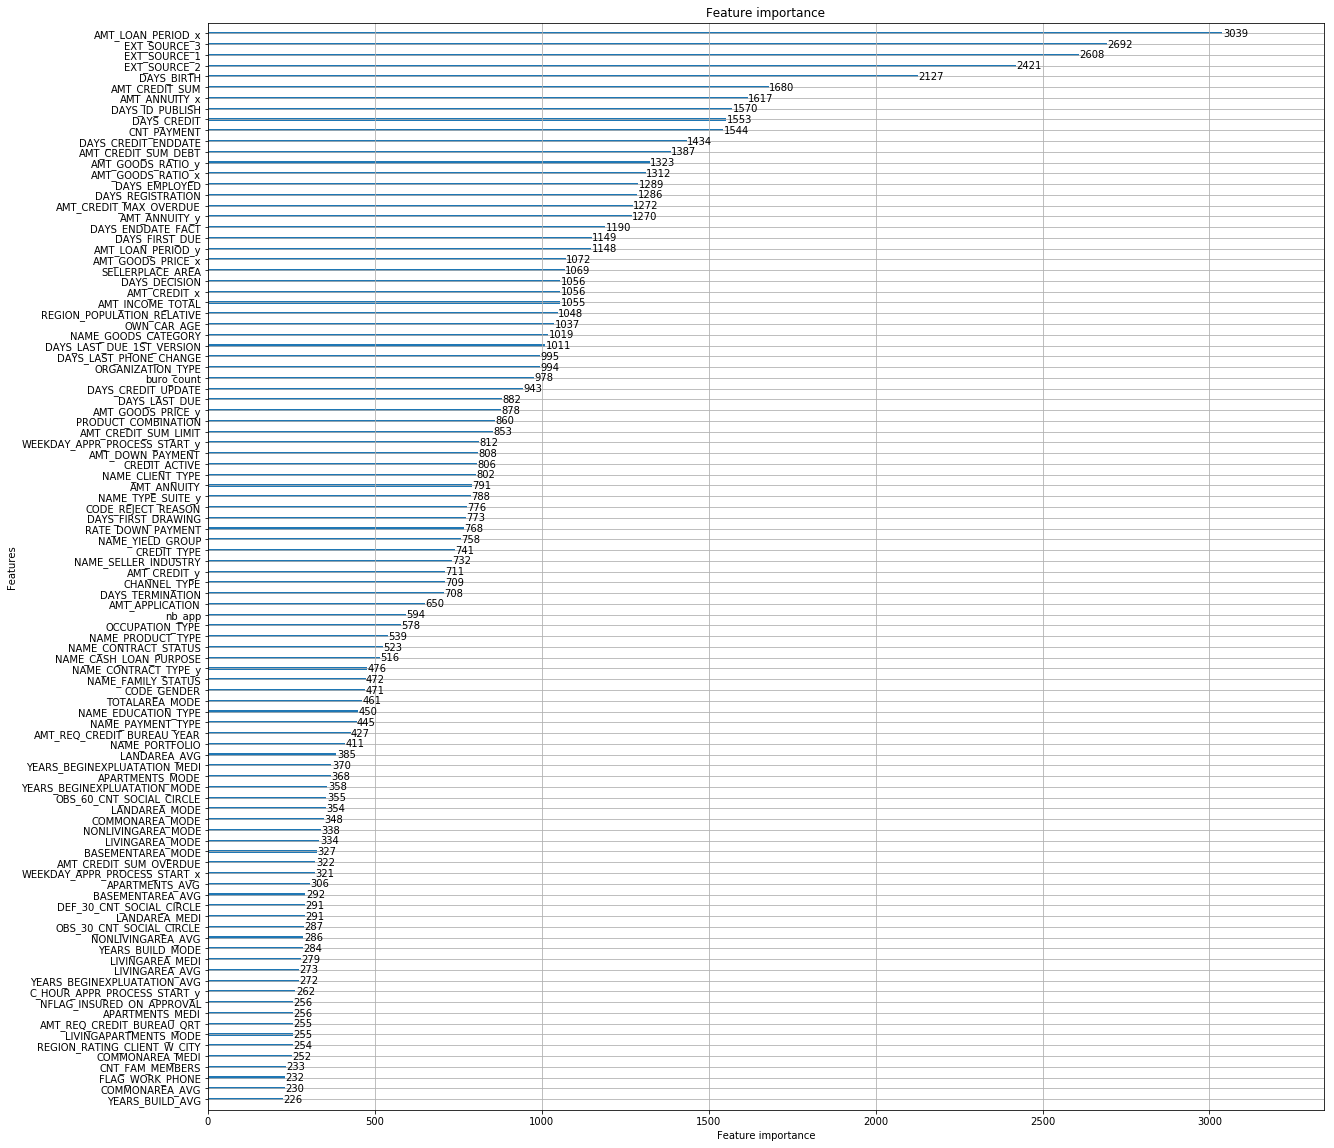

In [37]:
import lightgbm.plotting

lightgbm.plotting.plot_importance(clf, max_num_features=100, figsize=(20, 20))